# Quantum linear solver based on QSVT

The code here can be integrated as part of a larger CFD solver, e.g., as in [qc-cfd repository](https://github.com/rolls-royce/qc-cfd/tree/main/1D-Nozzle).
In particular, instead of calling a classical solver, e.g., `x = sparse.linalg.spsolve(mat_raw_scr, b_raw)`, one can call the quantum solver `qsvt_solver(mat_raw_scr, b_raw,...)`.

We implemented two versions for block-encoding, one based on Pauli decomposition of the matrix, and another one based on decomposing the matrix to a finite set of diagonals.

In [1]:
!pip install -qq -U "classiq[qsp]"
!pip install -qq "classiq[chemistry]"

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
from cheb_utils import *
from classical_functions_be import *
from quantum_functions_be import *
from scipy import sparse

from classiq import *
from classiq.applications.qsp import qsvt_phases

np.random.seed(53)

Define functions to get properties of the block-encoding.

In [3]:
PAULI_TRIM_REL_TOL = 0.1


def get_pauli_be(mat_raw_scr):
    """
    Get relevant block-encoding properties for `lcu_paulis_graycode` block encoding,

    Parameters
    ----------
    mat_raw_scr : scipy.sparse.spmatrix
        Square sparse matrix of shape (N, N), real or complex, to be block-encoded.

    Returns
    -------
    data_size : int
       Size of the data variable.
    block_size : int
        Size of the block variable.
    be_scaling_factor : float
        The scaling factor of the block-encoding unitary
    BlockEncodedState : QStruct
        QSVT-compatible QStruct holding the quantum variables, with fields:
          - data  : QNum[data_size]
          - block : QNum[block_size]
    be_qfunc : qfunc
        Quantum function that implements the block encoding. Signature:
        be_qfunc(be: BlockEncodedState) → None
    """
    rval = mat_raw_scr.data
    col = mat_raw_scr.indices
    rowstt = mat_raw_scr.indptr
    nr = mat_raw_scr.shape[0]

    raw_size = mat_raw_scr.shape[0]
    data_size = max(1, (raw_size - 1).bit_length())

    # Set to_symmetrize=False, since we are working with QSVT
    paulis_list, transform_matrix = initialize_paulis_from_csr(
        rowstt, col, data_size, to_symmetrize=False
    )

    qubit_op = eval_pauli_op(paulis_list, transform_matrix, rval)
    qubit_op.compress(1e-12)
    hamiltonian = of_op_to_cl_op(qubit_op)
    hamiltonian_trimmed = trim_hamiltonian(
        hamiltonian, PAULI_TRIM_REL_TOL, jump_threshold=1.1
    )

    be_scaling_factor = sum(
        [np.abs(term.coefficient) for term in hamiltonian_trimmed.terms]
    )
    block_size = size = max(1, (len(hamiltonian_trimmed.terms) - 1).bit_length())

    hamiltonian_trimmed = hamiltonian_trimmed * (1 / be_scaling_factor)

    print(
        f"number of Paulis before/after trimming {len(hamiltonian.terms)}/{len(hamiltonian_trimmed.terms)}"
    )

    class BlockEncodedState(QStruct):
        data: QNum[data_size]
        block: QNum[block_size]

    @qfunc
    def be_qfunc(be: BlockEncodedState):
        lcu_paulis_graycode(hamiltonian_trimmed.terms, be.data, be.block)

    return data_size, block_size, be_scaling_factor, BlockEncodedState, be_qfunc


def get_banded_diags_be(mat_raw_scr):
    """
    Get relevant block-encoding properties for `block_encode_banded` block encoding,

    Parameters
    ----------
    mat_raw_scr : scipy.sparse.spmatrix
        Square sparse matrix of shape (N, N), real or complex, to be block-encoded.

    Returns
    -------
    data_size : int
       Size of the data variable.
    block_size : int
        Size of the block variable.
    be_scaling_factor : float
        The scaling factor of the block-encoding unitary
    BlockEncodedState : QStruct
        QSVT-compatible QStruct holding the quantum variables, with fields:
          - data  : QNum[data_size]
          - block : QNum[block_size]
    be_qfunc : qfunc
        Quantum function that implements the block encoding. Signature:
        be_qfunc(be: BlockEncodedState) → None
    """
    raw_size = mat_raw_scr.shape[0]
    data_size = max(1, (raw_size - 1).bit_length())
    offsets, diags, diags_maxima, prepare_norm = get_be_banded_data(mat_raw_scr)
    block_size = int(np.ceil(np.log2(len(offsets)))) + 1
    be_scaling_factor = prepare_norm

    class BlockEncodedState(QStruct):
        data: QNum[data_size]
        block: QNum[block_size]

    @qfunc
    def be_qfunc(be: BlockEncodedState):
        block_encode_banded(
            offsets=offsets,
            diags=diags,
            prep_diag=diags_maxima,
            block=be.block,
            data=be.data,
        )

    return data_size, block_size, be_scaling_factor, BlockEncodedState, be_qfunc

The solvers were developed in the framework of exploring their performance in hybrid CFD schemes. For simplicity, it is assumed that all the properties of the matrices are known explicitly. In particular, we calculate its sigular values for identyfing the range in which we apply the inversion polnomial.

In [4]:
def get_svd_range(mat_raw_scr):
    mat_raw = mat_raw_scr.toarray()
    svd = np.linalg.svd(mat_raw)[1]
    w_min = min(svd)
    w_max = max(svd)
    return w_min, w_max

In [5]:
def qsvt_solver(
    mat_raw_scr,
    b_raw,
    poly_degree,
    be_method="banded",
    cheb_approx_type="optimized",
    preferences=Preferences(),
    constraints=Constraints(),
    qmod_name=None,
):

    SCALE = 0.5
    b_norm = np.linalg.norm(b_raw)  # b normalization
    b_normalized = b_raw / b_norm

    # Define block encoding
    if be_method == "pauli":
        data_size, block_size, be_scaling_factor, BlockEncodedState, be_qfunc = (
            get_pauli_be(mat_raw_scr)
        )
        print(
            f"Pauli block encoding with block size {block_size} and scaling factor {be_scaling_factor}"
        )

    elif be_method == "banded":
        data_size, block_size, be_scaling_factor, BlockEncodedState, be_qfunc = (
            get_banded_diags_be(mat_raw_scr)
        )
        print(
            f"Banded diagonal block encoding with block size {block_size} and scaling factor {be_scaling_factor}"
        )

    # Get SVD range
    w_min, w_max = get_svd_range(mat_raw_scr / be_scaling_factor)
    # Get Chebyshev polynomial and the corresponding QSVT angles
    pcoefs, poly_scale = get_cheb_coeff(
        w_min, poly_degree, w_max, scale=SCALE, method=cheb_approx_type, epsilon=0.01
    )
    inv_phases = qsvt_phases(pcoefs, tol=0.001)

    # Define QSVT projector
    @qfunc
    def projector(be: BlockEncodedState, res: QBit):
        res ^= be.block == 0

    @qfunc
    def main(
        qsvt_aux: Output[QBit],
        data: Output[QNum[data_size]],
        block: Output[QNum[block_size]],
    ):
        allocate(qsvt_aux)
        allocate(block)
        prepare_amplitudes(b_normalized.tolist(), 0, data)

        be_state = BlockEncodedState()

        within_apply(
            lambda: bind([data, block], be_state),
            lambda: qsvt_inversion(
                inv_phases,
                lambda aux: projector(be_state, aux),
                lambda: be_qfunc(be_state),
                qsvt_aux,
            ),
        )

    if qmod_name is not None:
        write_qmod(main, qmod_name, symbolic_only=False)

    start_time_syn = time.time()
    qprog = synthesize(main, preferences=preferences, constraints=constraints)
    print("time to syn:", time.time() - start_time_syn)

    execution_preferences = ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
        ),
    )

    start_time_exe = time.time()
    with ExecutionSession(qprog, execution_preferences) as es:
        es.set_measured_state_filter("block", lambda state: state == 0.0)
        es.set_measured_state_filter("qsvt_aux", lambda state: state == 0.0)
        results = es.sample()
    print("time to exe:", time.time() - start_time_exe)

    resulting_state = get_projected_state_vector(results, "data")

    normalization_factor = (be_scaling_factor * poly_scale) / b_norm

    return resulting_state / normalization_factor, qprog

In [6]:
# For faster results use the commented out preferences


prefs = Preferences()

# prefs = Preferences(
#     transpilation_option="none", optimization_level=0, debug_mode=False, qasm3=True
# )
poly_degree = 101

We run two examples, for the two different block encoding, but using the same polynomial degree.

In [7]:
import pathlib

path = (
    pathlib.Path(__file__).parent.resolve()
    if "__file__" in locals()
    else pathlib.Path(".")
)

In [8]:
mat_name = "nozzle_small_scr"
matfile = "matrices/" + mat_name + ".npz"
mat_raw_scr = sparse.load_npz(path / matfile)

b_raw = np.load(path / "matrices/b_nozzle_small.npy")
raw_mat_qubits = len(b_raw).bit_length() - 1  # matrix raw size

print(f"Raw matrix size: {raw_mat_qubits} qubits.")

Raw matrix size: 3 qubits.


In [9]:
qsol_banded, qprog_banded = qsvt_solver(
    mat_raw_scr,
    b_raw,
    poly_degree,
    be_method="banded",
    preferences=prefs,
    constraints=Constraints(optimization_parameter="width"),
    qmod_name="qsvt_solver_banded_be",
)
show(qprog_banded)

Banded diagonal block encoding with block size 3 and scaling factor 3.8927056451476174
For error 0.01, and given kappa, the needed polynomial degree is: 591
Taking optimized expansion from literature, with degree 101
time to syn: 118.76460003852844
time to exe: 12.583821058273315
Quantum program link: https://platform.classiq.io/circuit/36cmEQmYNOVwmxq09cW1Pxntbqr


In [10]:
qsol_pauli, qprog_pauli = qsvt_solver(
    mat_raw_scr,
    b_raw,
    poly_degree,
    be_method="pauli",
    preferences=prefs,
    constraints=Constraints(optimization_parameter="width"),
    qmod_name="qsvt_solver_pauli_be",
)
show(qprog_pauli)

number of Paulis before/after trimming 24/20
Pauli block encoding with block size 5 and scaling factor 5.557119918538639
For error 0.01, and given kappa, the needed polynomial degree is: 885
Taking optimized expansion from literature, with degree 101
time to syn: 169.37596011161804
time to exe: 17.412251949310303
Quantum program link: https://platform.classiq.io/circuit/36cmdIpDThjRGtPTxzdJGjNkfqk


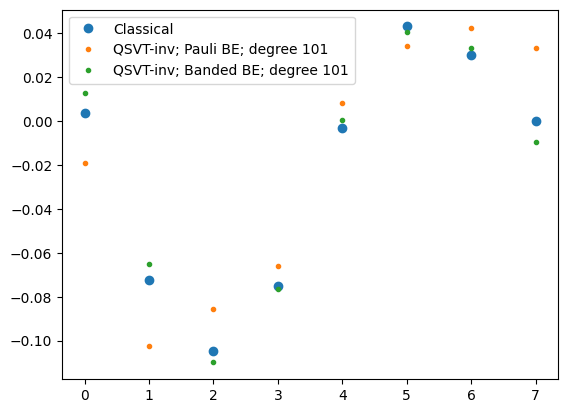

In [11]:
mat_raw = mat_raw_scr.toarray()
expected_sol = np.linalg.solve(mat_raw, b_raw)
plt.plot(expected_sol, "o", label="Classical")
ext_idx = np.argmax(np.abs(expected_sol))
correct_sign = np.sign(expected_sol[ext_idx]) / np.sign(qsol_pauli[ext_idx])
qsol_pauli *= correct_sign
plt.plot(qsol_pauli, ".", label=f"QSVT-inv; Pauli BE; degree {poly_degree}")

correct_sign = np.sign(expected_sol[ext_idx]) / np.sign(qsol_banded[ext_idx])
qsol_banded *= correct_sign
plt.plot(qsol_banded, ".", label=f"QSVT-inv; Banded BE; degree {poly_degree}")
plt.legend()

**We can see that the results is better for the banded diagonal block-encoding. This is because it has a better scaling factor, and thus a better approximation for a given polynomial degree.**

In [12]:
assert np.linalg.norm(qsol_banded - expected_sol) < 0.2
assert np.linalg.norm(qsol_pauli - expected_sol) < 0.2